In [582]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.stats import iqr
import pandas as pd
import random

In [583]:
# Read in data
data = pd.read_csv('labels.txt')
len(data)

152

In [584]:
data = data[data.ClusterSize>10]
len(data)

137

In [585]:
data = data.reindex(np.random.permutation(data.index))

cutoff = int(0.7*len(data))

train_data = data[:cutoff]
test_data = data[cutoff:]

In [586]:
X = np.array([data.MedLength,data.IqrAngle]).T
# X = data.Avglength.as_matrix().reshape(-1,1)
y = data.Label.as_matrix()

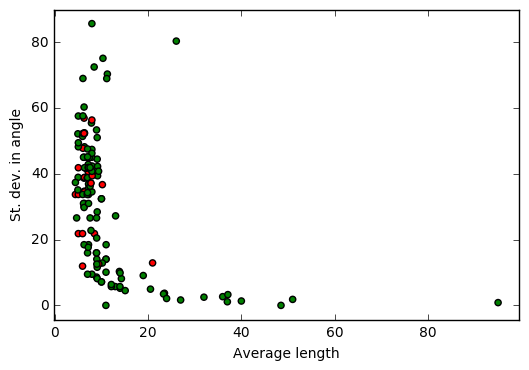

In [587]:
colors = ['g' if label else 'r' for label in data.Label]

plt.scatter(X[:,0],X[:,1],c=colors)
plt.axis('equal')
plt.xlabel('Average length')
plt.ylabel('St. dev. in angle')
# plt.plot([x_dec,x_dec],[np.min(data.Stdangle),np.max(data.Stdangle)])
plt.axis('tight')
plt.show()

In [588]:
X_train = np.array([train_data.MedLength,train_data.IqrAngle]).T
X_test = np.array([test_data.MedLength,test_data.IqrAngle]).T
y_train = train_data.Label.as_matrix()
y_test = test_data.Label.as_matrix()

In [589]:
# DO KNN
from sklearn.neighbors import KNeighborsClassifier

In [590]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [591]:
# Prediction
y_pred_train = neigh.predict(X_train)
y_pred_test = neigh.predict(X_test)

In [592]:
train_err = float(sum(y_pred_train==y_train))/len(y_train)
test_err = float(sum(y_pred_test==y_test))/len(y_test)
print train_err
print test_err

0.863157894737
0.857142857143


In [593]:
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])

In [594]:
y_pred_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [ ]:
# NEED TO COMPUTE specificity and sensitivity


In [ ]:
TP = 

In [595]:
# NEED MORE NEGATIVE EXAMPLES

In [596]:
# Training error and test error as a function of n_neighbors

In [597]:
# Pick number of neigbors using cross-validation

In [598]:

# # SVM

# from sklearn.svm import SVC

# clf = SVC()
# model = clf.fit(X, y) 

# # decision boundary for just length
# xx = np.linspace(np.min(X),np.max(X),100)

# pred_prev = 0
# for x in xx:
#     pred = clf.predict(x)
#     if pred[0] > pred_prev:
#         x_dec = x
#         break
#     pred_prev = pred

# predictions = clf.predict(X)

# colors = ['g' if label else 'r' for label in data.Label]

# plt.scatter(data.Avglength,data.Stdangle,c=colors)
# plt.axis('equal')
# plt.xlabel('Average length')
# plt.ylabel('St. dev. in angle')
# # plt.plot([x_dec,x_dec],[np.min(data.Stdangle),np.max(data.Stdangle)])
# plt.axis('tight')
# plt.show()